# DDPLKO Moduł 3 - praca domowa - pierwszy własny trening CNN

In [ ]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import os

# Wybierz 10 klas

Poniżej przygotuj listę 10 klas z:
https://quickdraw.withgoogle.com/data

> nazwy takie jak nazwy obiektów (wyświetlane po najechaniu lub kliknięciu)

In [ ]:
class_names = ["airplane", "banana", "cookie", "diamond", "dog", "hot air balloon", "knife" ,"parachute", "scissors", "wine glass"]

## Test

In [ ]:
assert len(class_names)==10, 'Nazw powinno być dokładnie 10'
for i in range(len(class_names)):
    assert type(class_names[i])==str, 'Każda z nazw powinna być typu str'
    assert '/' not in class_names[i], 'Same nazwy klas, ze spacjami, bez ukośników'

# Wczytanie danych
Pobieranie plików z obrazami w formaci npy (numpy)

In [ ]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')

    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

## Wczytywanie z plików .npy
Dane znajdziesz w tablicy data

In [ ]:
data = []
for name in class_names:
    file_name = name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

# Liczebności i wymiary zdjęć
Wypisz nazwę i shape dla każdej klasy

In [ ]:
for i, class_name in enumerate(class_names):
    print(f'{class_name:<16} {data[i].shape}')

Poniżej zwizualizuj liczbę zdjęć per klasę:

In [ ]:
import seaborn as sns
import pandas as pd

counts = [ d.shape[0] for d in data ]
dataset_summary = pd.DataFrame({"class": class_names, "count": counts}).sort_values(by='count', ascending=False)

fig, ax = plt.subplots(1,1, figsize=(12,11))
sns.barplot(x=dataset_summary["count"], y=dataset_summary["class"], palette=sns.color_palette("hls", len(class_names)), ax=ax)

# Wizualizacja danych
Dane są w macierzach dwuwyamirowych,
aby je poprawnie wyświetlić jako obraz,
należy je przekonwertować do 3 wymiarów:

- numer zdjęcia
- wysokość
- szerokość

Tu pomoże `reshape` z numpy.

## Konwersja do (-1, 28, 28)

In [ ]:
example_images = []

for i, class_name in enumerate(class_names):
    example_images.append(data[i][0].reshape(-1, 28, 28))

Wyświetl po jednym przykładzie z każdej klasy.

Możesz skorzystać z `plt.subplot`

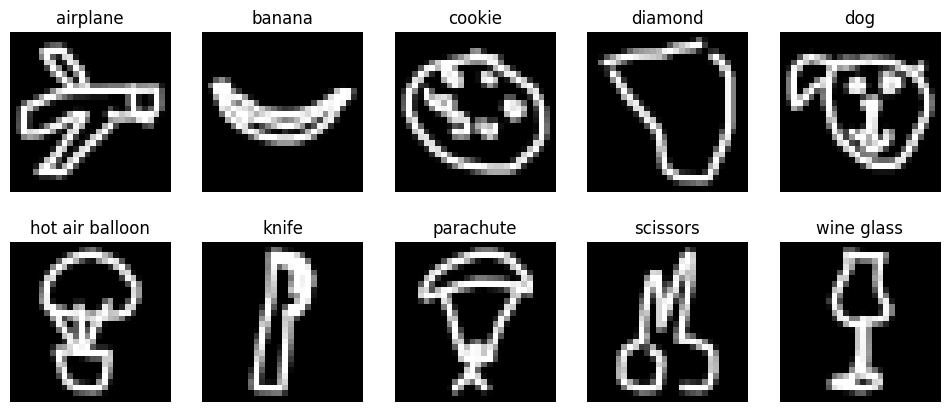

In [9]:
fig, axis = plt.subplots(2,5, figsize=(12,5))

for i, ax in enumerate(axis.flatten()):
    image_reshaped = example_images[i].reshape(28,28) # bez tego dostajemy TypeError: Invalid shape (1, 28, 28) for image data
    ax.imshow(image_reshaped, cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

## Obraz średni
Jak podobne do siebie są obrazy z poszczególnych klas?

Oblicz i wyświetl średni obraz dla wszystkich klas.

Możesz skorzystać z `np.mean`

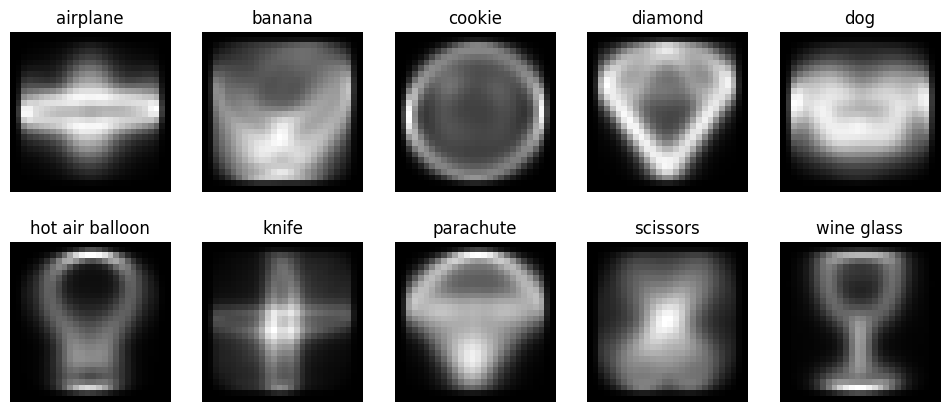

In [10]:
mean_images = []

for i, class_name in enumerate(class_names):
    mean_image = np.mean(data[i], axis=0)
    mean_images.append(mean_image)


fig, axis = plt.subplots(2,5, figsize=(12,5))

for i, ax in enumerate(axis.flatten()):
    image_reshaped = mean_images[i].reshape(28,28)
    ax.imshow(image_reshaped, cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

# Trening w TensorFlow

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
#import tensorflow as tf

#for gpu in tf.config.list_physical_devices('GPU'):
#    tf.config.experimental.set_memory_growth(gpu, True)

# Przygotowanie danych
Przygotowanie listy etykiet oraz macierzy zdjęć
Przygotuj:
- [ ] X - jako macierz numpy w której będą wszystkie zdjęcia
- [ ] y - jako macierz numpy w której będą wszystkie etykiety (jako numer klasy)
- [ ] wykonaj reshape dla X do (-1,28,28,1)

Co może Ci się przydać:
- łączenie macierzy - np.concatenate
- mnożenie listy przez N zwraca listę z N-krotnie więcej elementami [0]*3 ==>> [0,0,0]
- konwersja listy do macierzy numpy - np.array([0,1,2,3])

Korzystając z pythonowych zapisów możesz to zrobić w jednej lini per zmienną, nie zapisuj w obu w jednej, bo to już nie będzie czytelne (tak, da się)

In [12]:
X = np.concatenate(data).reshape(-1,28,28,1)
y = np.concatenate([np.full(d.shape[0], i) for i, d in enumerate(data)])

## Test

In [13]:
assert type(X)==np.ndarray,                 "X powinno być macierzą numpy"
assert type(y)==np.ndarray,                 "y powinno być macierzą numpy"
assert len(X)==sum([len(_) for _ in data]), "X powinno mieć tyle samo przykładów ile jest w data"
assert len(y)==sum([len(_) for _ in data]), "Y powinno mieć tyle samo etykiet ile jest przykładów w data"
assert len(X.shape)==4,                     "X - Wymagane są 4 wymiary - index, wysokość, szerokość, głębokość"
assert len(y.shape)==1,                     "y - Wymagany jest 1 wymiar"
assert X.shape[1:]==(28,28,1),              "Zdjęcia powinny być 28x28x1"

## Normalizacja

Przygotuj dane (X) w taki sposób by wartości były bliskie zera.
W celu zachowania prostoty - podziel wartości przez 255, a nie przez najwyższą wartość.
Nie przesuwaj średniej do zera, i nie normalizuj odchylenia.

In [14]:
X = X / 255

### Test

In [15]:
assert np.max(X)<=1, "Największa wartość nie może być większa niż 1"
assert np.min(X)>=0, "Pracujmy w zakresie od 0..1"

## Podział zbioru danych

Podziel zbiór zachowując ten sam stosunek liczby klas w train i val.
Do podziału użyj `train_test_split` z `sklearn`.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

In [17]:
del X, y

### Wizualizacja podziału

Przygotuj wykres, który pokaże jak dane train i val sumują się dla poszczególnych klas (trening+val powinny być jako jeden słupek, sumarycznie wysokości słupka przed podziałem). Podpowiedź - stacked bar plot.
Przygotuj drugi wykres, który pokaże czy zbiór danych jest podzielony z zachowaniem stosunku liczebności poszczególnych klas (zachowanie procentowych udziałów klas w zbiorze).

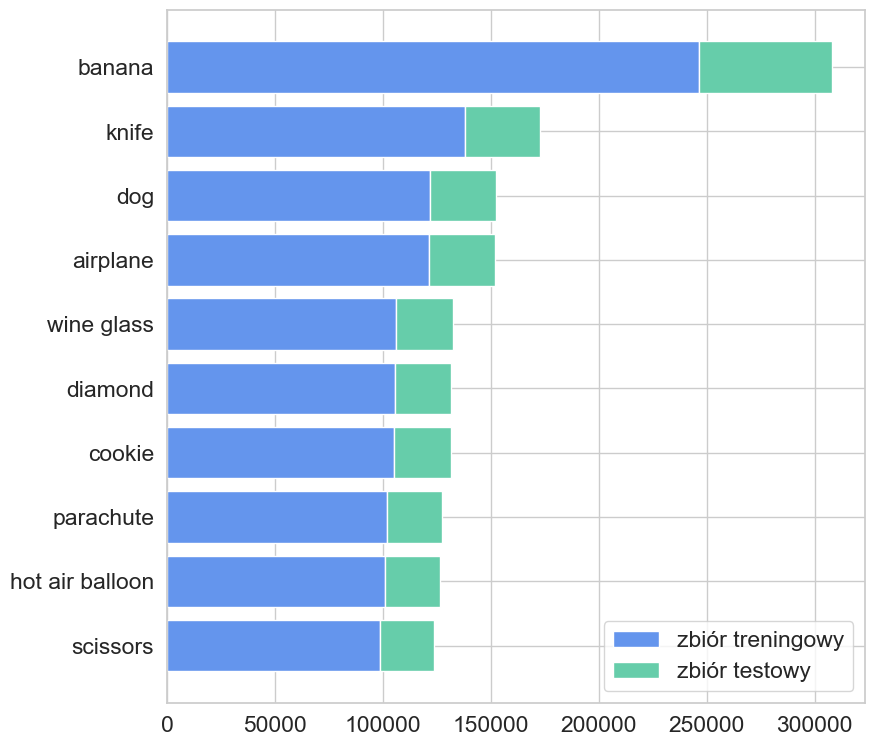

In [18]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_val, return_counts=True)

ds_summary = pd.DataFrame({"class": class_names, "train_count": train_counts, "test_count": test_counts }).sort_values(by="train_count", ascending=True)
ds_summary

fig, ax = plt.subplots(1, 1, figsize=(9,9))

ax.barh(y=ds_summary['class'], width=ds_summary['train_count'], label="zbiór treningowy", color='cornflowerblue')
ax.barh(y=ds_summary['class'], width=ds_summary['test_count'], label="zbiór testowy", color='mediumaquamarine', left=ds_summary['train_count'])
plt.legend()
plt.show()

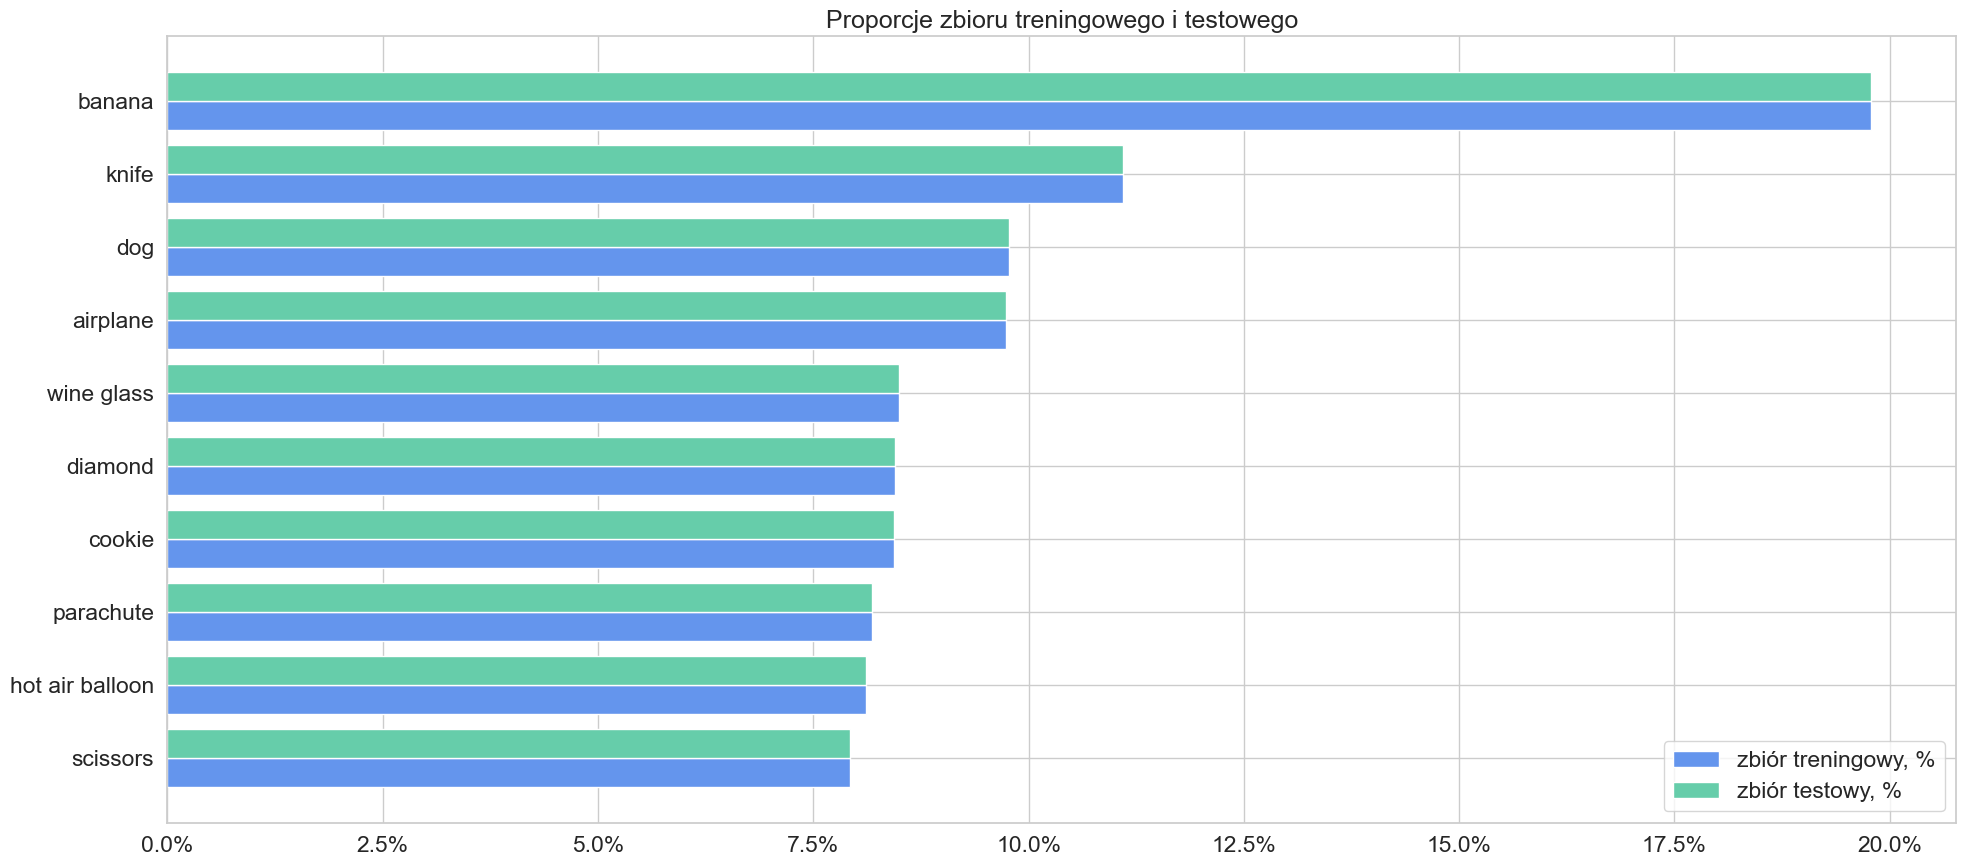

In [19]:
import matplotlib.ticker as mtick

total_train_count = ds_summary['train_count'].sum()
total_test_count = ds_summary['test_count'].sum()

ds_summary['train_count_pct'] = ds_summary['train_count'] / total_train_count * 100
ds_summary['test_count_pct'] = ds_summary['test_count'] / total_test_count * 100


fig, ax = plt.subplots(1, 1, figsize=(20,9), sharey=True)

ax.set_title("Proporcje zbioru treningowego i testowego")
Y_axis = np.arange(len(ds_summary['class']))

ax.barh(Y_axis - 0.2, ds_summary['train_count_pct'], 0.4, label="zbiór treningowy, %", color='cornflowerblue')
ax.barh(Y_axis + 0.2, ds_summary['test_count_pct'], 0.4, label="zbiór testowy, %", color='mediumaquamarine')

plt.yticks(Y_axis, ds_summary['class'])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
plt.legend()
plt.show()

## Test podziału danych

In [20]:
assert all((np.unique(y_train, return_counts=True)[1]/len(y_train)).round(2) == (np.unique(y_val, return_counts=True)[1]/len(y_val)).round(2)), "Nierówny podział danych, zadbaj by rozkład w train i val były takie same"

# Przygotuj model

- Wykorzystaj warstwy konwolucyjne (minimum 1), pamiętaj o funkcjach aktywacji
- Wykorzystaj Flatten
- Model powinien mieć:
  - wejście 28,28,1
  - 10 wyjść
  - Adama jako optymalizator
  - sparse CE loss
  - warto dodać accuracy jako metrykę
  
Pooling wprowadzimy w module 4, a i bez niego uzyskasz >80% accuracy.

# Pytorch Lightning

In [21]:
#! pip install lightning

In [22]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

from torchmetrics.functional.classification.accuracy import accuracy

C:\Users\Wiktor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [23]:
# check if cuda is available, if so check gpu(0) device name
check_cuda = torch.cuda.is_available()

gpu_name = torch.cuda.get_device_name(0)

print("Cuda available: ", check_cuda, "\nGPU Name: ", gpu_name)

Cuda available:  True 
GPU Name:  NVIDIA GeForce RTX 4070 Ti


## klasa QuickDrawCNN_PL

- [ ] Zamień dane na Tensory
- [ ] Przekonwertuj dane do formatu NCHW z NHWC
- [ ] Zapewnij odpowiedni typ danych dla etykiet
- [ ] Przygotuj zbiór danych - skorzystaj z `TensorDataset`
- [ ] Zaprojektuj architekturę sieci z minimum 1 warstwą konwolucyjną

In [24]:
class QuickDrawCNN_PL(pl.LightningModule):
    def __init__(self, X_train,y_train,X_val,y_val, batch_size):
        super().__init__()

        self.X_train = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
        self.X_val = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
        self.y_train = torch.LongTensor(y_train)
        self.y_val = torch.LongTensor(y_val)
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, self.y_val)

        self.batch_size = batch_size

        ####################
        ### Don't chagne ###
        assert type(self.X_train)==torch.Tensor
        assert self.X_train.shape==torch.Size([len(X_train), 1, 28, 28])
        assert self.X_train.dtype==torch.float32, "Typ X_train niepoprawny"

        assert type(self.y_train)==torch.Tensor
        assert self.y_train.shape==torch.Size([len(X_train)])
        assert self.y_train.dtype==torch.int64, "Typ y_train niepoprawny"

        assert type(self.X_val)==torch.Tensor
        assert self.X_val.shape==torch.Size([len(X_val), 1, 28, 28])
        assert self.X_val.dtype==torch.float32, "Typ X_val niepoprawny"

        assert type(self.y_val)==torch.Tensor
        assert self.y_val.shape==torch.Size([len(y_val)])
        assert self.y_val.dtype==torch.int64, "Typ y_val niepoprawny"
        ### Don't chagne ###
        ####################


        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims

        self.model = nn.Sequential(
            nn.Conv2d(channels, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7744, self.num_classes), # ustawilem 7744, w przeciwnym razie nie
        )

        ####################
        ### Don't chagne ###
        assert any(['Conv2d' in str(_) for _ in self.model]), "Zastosuj przynajmniej jedną warstwę Conv2d"
        assert len([_ for _ in self.model if 'Conv2d' in str(_)])==len([_ for _ in self.model if 'ReLU' in str(_)]), "Po każdej warstwie Conv2d zastosuj funkcję aktywacji ReLU"
        ### Don't chagne ###
        ####################
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_classes)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=16)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=16)

### Trening

- [x] Uruchom trening na 10 epok
- [x] Batch size ustaw na wartość np. od 32 do 256 (możesz mniej, możesz więcej)
- [x] Utwórz instancję klasy QuickDrawCNN_PL
- [x] Przygotuj `Trainer`
- [x] Uruchom trening

In [25]:
# You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. 
# To properly utilize them, you should set 
# `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance
torch.set_float32_matmul_precision('medium')

model = QuickDrawCNN_PL(X_train,y_train,X_val,y_val, 128*4)
logger = TensorBoardLogger("lightning_logs", name="modul_3")

trainer = pl.Trainer(
    max_epochs=10, 
    precision=16, 
    accelerator="gpu",
    logger=logger,
)

trainer.fit(model)

C:\Users\Wiktor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\fabric\connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81.0 K
-------------------------------------
81.0 K    Trainable params
0         Non-trainable params
81.0 K    Total params
0.324     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 2433/2433 [00:42<00:00, 57.78it/s, v_num=1, val_loss=0.249, val_acc=0.928]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2433/2433 [00:42<00:00, 57.77it/s, v_num=1, val_loss=0.249, val_acc=0.928]


### Uruchom TensorBoard do wizualizacji wyników

In [30]:
#%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 10108), started 23:17:08 ago. (Use '!kill 10108' to kill it.)

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.